# Stabilized Video
Make a stabilized video given the FFT-computed drifts

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import animation
from pathlib import Path
from tqdm import tqdm
import imageio.v3 as iio
import pandas as pd
import numpy as np
import shutil

Configuration

In [2]:
run_directory = '../data/8bitTIFF-video26-575C/'

Determine location of keys files

In [3]:
run_directory = Path(run_directory)
out_directory = Path('output') / run_directory.name
drift_file = out_directory / 'drifts-fft.csv'
defect_file = out_directory / 'defect-details.json'

## Load in the Drifts
They are in a file in the `drifts` directory

In [4]:
drifts = pd.read_csv(drift_file)
for c in ['x', 'y']:
    drifts[c] = -np.array(np.round(drifts[c]), dtype=np.int_)
drifts.head()

,frame,x,y
0,0,0,0
1,1,0,0
2,2,0,1
3,3,1,0
4,4,0,0


## Determine the Size of the Total Image
Get the total area covered by the images

In [5]:
images = sorted((run_directory).glob('*tif'))
masks = sorted((run_directory / 'masks').glob('*tif'))
print(f'Found {len(images)} images')

Found 969 images


Get the coordinates of the top left and bottom right of where we image

In [6]:
image_size = iio.imread(images[0]).shape

In [7]:
bottom_right = drifts[['x', 'y']].max() + image_size

In [8]:
top_left = drifts[['x', 'y']].min().values

In [9]:
top_left

array([-1,  0])

Get the union size

In [10]:
total_size = bottom_right - top_left
print(f'Total image size {"x".join(map(str, total_size))}: {total_size.prod() / 1e6:.1f} Mpixels')

Total image size 1102x1213: 1.3 Mpixels


## Make a Function to Plot a Drift-Corrected Frame
Place an image in the correct location given its drift

In [11]:
drifts.iloc[600]

frame    600
x         43
y         90
Name: 600, dtype: int64

In [12]:
def load_image(index: int) -> tuple[np.ndarray, np.ndarray]:
    """Place the image and mask on a canvas the size of the whole video
    
    Args:
        index: Index of the frame to be rendered
    Returns:
        Image in the total context
    """
    
    # Make the total output frame
    output_image = np.zeros((*total_size, 4), dtype=np.uint8)
    output_mask = np.zeros((*total_size, 4), dtype=np.uint8)
    
    # Make the output mask red
    output_mask[:, :, :3] = [255, 0, 0]
    
    # Get the offset of the current frame for the top left
    offset = drifts.iloc[index][['x', 'y']].values - top_left
    
    # Load the image and place in output image
    image = iio.imread(images[index])
    output_image[offset[0]:offset[0] + image.shape[0], offset[1]:offset[1] + image.shape[1], -1] = image
    output_mask[offset[0]:offset[0] + image.shape[0], offset[1]:offset[1] + image.shape[1], -1] = iio.imread(masks[index])
    return output_image, output_mask

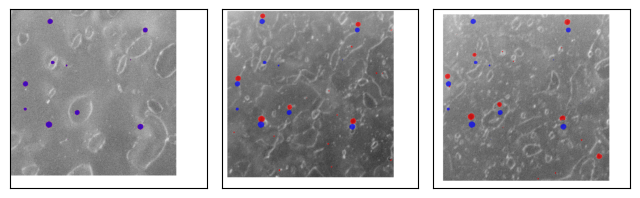

In [13]:
fig, axs = plt.subplots(1, 3, figsize=(6.5, 2.5))

# Get the starting mask
image_0, mask_0 = load_image(0)
mask_0[:, :, :3] = [0, 0, 255]

for i, ax in zip([0, 250, 500], axs):
    image, mask = load_image(i)
    
    # Plot 
    ax.imshow(image)
    ax.imshow(mask, alpha=0.7)
    ax.imshow(mask_0, alpha=0.7)

    ax.set_xticks([])
    ax.set_yticks([])
    
fig.tight_layout(pad=1.08)

Our changes allow the image to move around

## Render the Video
Show the image and the masks moving around

In [14]:
image, mask = load_image(0)

In [15]:
(out_directory / 'videos').mkdir(exist_ok=True)

972it [03:01,  5.25it/s]                                                                                                                                                                                                                                                                  

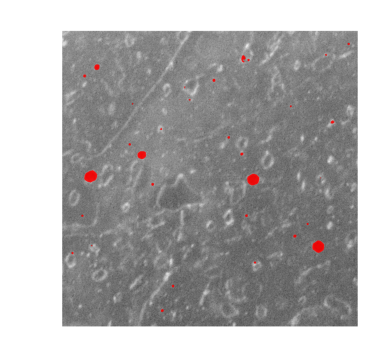

In [16]:
fig, ax = plt.subplots(figsize=(3.5, 3.5 * total_size[0] / total_size[1]))

ax.axison=False

pbar = tqdm(total=len(images))
im1 = ax.imshow(image, cmap='gray_r')
im2 = ax.imshow(mask, alpha=0.9, cmap='Reds', vmin=0)

def plot_frame(i):
    pbar.update(1)
    # Get the frames
    image, mask = load_image(i)
    
    # Plot both
    im1.set_data(image)
    im2.set_data(mask)
    
    # Write out the current frame
    #fig.savefig(frame_dir / f'frame-{i:04d}.tiff', dpi=320, pil_kwargs={"compression": "tiff_lzw"})
    return im1, im2
    
fig.tight_layout(pad=0)

ani = animation.FuncAnimation(fig, plot_frame, frames=len(images), interval=3000 / len(images), blit=True)
writer = animation.FFMpegWriter(fps=15, bitrate=16000)
ani.save(out_directory / "videos/drift-corrected.mp4", writer=writer, dpi=320)